# **Creating results for 1 dimensional Riemann problems**
This notebook is for easily creating results to use in the thesis. The code is based on code from the development stage, found in `dev_pkg_1dim.ipynb` which is a notebook used for testing everything while developing.

## **How to produce results**
1. Choose parameters. Be wise on choice of destination to avoid overwriting.
2. Restart kernel and run all cells.

**NB**: `Make sure not to overwrite wanted material, thus choose destination and filename with care`**!!!**

In [1]:
from datetime import datetime
print("Last run:",datetime.today())

Last run: 2021-02-03 09:54:58.292187


## Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from riemannsolver import data1d
from riemannsolver import net_mlp1d as network
from riemannsolver import god_mlp1d as god_aprox
from riemannsolver import netplot
from riemannsolver import function
from riemannsolver import godunov as god_exact

from IPython.display import HTML
from tqdm import tqdm_notebook as tqdm

## **Parameters**

#### Flux and derivative

In [3]:
f = lambda u: u**2/2
dfdu = lambda u: u

#### Destination and filename

In [4]:
destination = "res/1dim/burgers/test"
name = "test"

#### Training and validation size

In [5]:
N = 100000
N_val = N//10

#### Network parameters

In [6]:
dimensions = (2,12,12,12,12,1)
epochs = 20
batchsize = 100

#### Mesh- and method-parameters

In [7]:
Nx = 50
T = 0.5
C = 0.5

In [8]:
import pandas as pd
pd.DataFrame([destination, name],columns=[""], index=["Destination", "Filename"])

,
Destination,res/1dim/burgers/test
Filename,test


In [9]:
#pd.DataFrame([dim for dim in dimensions],columns=["Nodes in network"], index=["Input", "Layer2", "Layer3", "Layer4", "Output"])

## Data

In [10]:
# training data
gen_trn = data1d.Dataset(N=N, f=f) 
gen_trn.create
gen_trn.save(destination=destination, filename=str(N//1000)+'k_'+name)
data_trn = gen_trn.get_data

# validation data
gen_val = data1d.Dataset(N=N_val, f=f) 
gen_val.create
gen_val.save(destination=destination, filename=str(N_val//1000)+'k_'+name)
#gen_val.save(destination=destination, filename=str(N_val//1000+1000)+'k_'+name)
data_val = gen_val.get_data


Data is saved in res/1dim/burgers/test/100k_test



Data is saved in res/1dim/burgers/test/10k_test


## Network

In [11]:
net = network.Network(
    N=N, 
    dimensions=dimensions,
    dfdu=dfdu
)

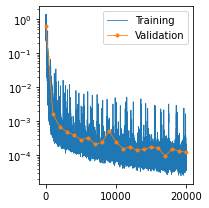

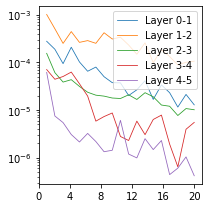

In [14]:
net.backward(
    epochs = epochs,
    batchsize = batchsize,
    data_train=data_trn,
    data_val=data_val,
    destination=destination,
    name=name
)
hist = net.history
hist_w = net.history_weight
netplt = netplot.Curve(hist, hist_w)
netplt.plot_history(destination=destination, name=name, show=True)
netplt.plot_weights(destination=destination, name=name, show=True)

## Approximate by Godunov

Initial function: heaviside


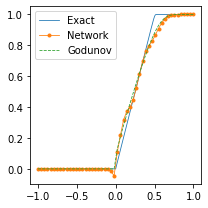

Relative error - godunov vs network:  0.025177824118999013
Initial function: reverseHeavi


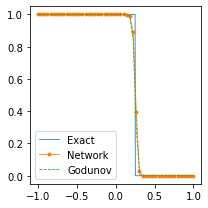

Relative error - godunov vs network:  0.020641520545571754
Initial function: inverse


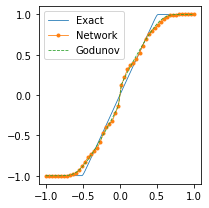

Relative error - godunov vs network:  0.020970486848056313
Initial function: trig


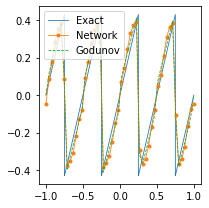

Relative error - godunov vs network:  0.1019313262622782


In [15]:
u0 = [
    lambda x: (x>=0).type(torch.float64), # Heaviside
    lambda x: (x<0).type(torch.float64), # Reversed Heaviside
    lambda x: ((-1)*(x<0) + (x>0)).type(torch.float64), # Inverse
    lambda x: np.sin(4*np.pi*x) # Trigonometric
]
bounds= ['neumann' for _ in range(3)]+['periodic']
labels = ['heaviside', 'reverseHeavi', 'inverse', 'trig']

for i in range(len(u0)):
    print("Initial function:",labels[i])
    # solve with network
    god_a = god_aprox.Godunov(
        f=f, dfdu=dfdu, u0=u0[i], 
        bnd_cond=bounds[i], 
        xmin=-1, xmax=1, Nx=Nx, 
        network=net.network, T=T, C=C
    )
    god_a.solve
    # solve exact
    god_e = god_exact.Godunov(
        f=f, dfdu=dfdu, u0=u0[i], 
        bnd_cond=bounds[i], 
        xmin=-1, xmax=1, Nx=8192, 
        T=T, C=C
    )
    god_e.solve
    # solve with godunov
    god_g = god_exact.Godunov(
        f=f, dfdu=dfdu, u0=u0[i], 
        bnd_cond=bounds[i], 
        xmin=-1, xmax=1, Nx=Nx, 
        T=T, C=C
    )
    god_g.solve
    # set visuals in netplot module
    netplt.god_net = god_a
    netplt.god_ext = god_e
    netplt.god_god = god_g
    # plot and save
    netplt.plot_solution_exact(destination=destination, name=labels[i]+'_'+name, show=True)
    netplt.plot_solution(destination=destination, name=labels[i]+'_'+name, show=False)
    netplt.plot_godunov(destination=destination, name=labels[i]+'_'+name, show=False)
    netplt.plot_exact(destination=destination, name=labels[i]+'_'+name, show=False)

    re = float(
        torch.sqrt(
            torch.sum( (god_a.u[-1]-god_g.u[-1])**2 )/torch.sum( (god_g.u[-1])**2 )
        )
    )
    print("Relative error - godunov vs network: ",re)